# Modello di Kuramoto_0:
# $\frac{d \theta _{i} }{dt} = \omega _i + \frac{K}{N}\sum_{j=1}^N A_{ij} \sin (\theta _j - \theta _i ), \ \ i = 1, ..., N$

# Modello di Kuramoto_scale_free:
# $\frac{d \theta _{i} }{dt} = \omega _i + \frac{K}{k_{i}}\sum_{j=1}^N A_{ij} \sin (\theta _j - \theta _i ), \ \ i = 1, ..., N$ 

In [1]:
import igraph as ig
import matplotlib.pyplot as plt
import random
import numpy as np
import copy
from scipy.integrate import odeint

%matplotlib widget
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
# It's also possible to use the reduced notation by directly setting font.family:
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "Helvetica"
})


In [203]:
# function used

def motion(_q_0, _omegas, _K, _t_max, _dt, network):
    debug = False
    # how many vertices (oscillators)?
    _N = len(network.vs.indices)
    q = _q_0
    t = 0
    q_plot = np.zeros((int(_t_max/_dt), _N))
    dq_plot = np.zeros((int(_t_max/_dt), _N))
    dq0 = _omegas
    for t_count in range(int(_t_max/dt)):
        if debug:   print("\n", t)        
        dq = kuramoto( q, t, _omegas, _K, network)
        q_plot[t_count] = q
        dq_plot[t_count] = dq
        if debug: print(dq)
#        q = eulero_esplicito(q, dq, dt)
        q = runge_kutta4( q, t, _omegas, _K, network, dt )
        q = q  % (2*np.pi)
        t += _dt
    return q_plot, dq_plot

def eulero_esplicito(q, dq, dt):
    return q + dq*dt

def runge_kutta4(q, t, omegas, _K, network, h):
    f = kuramoto
    k1_dot_q = f(q, t, omegas, _K, network )
    k2_dot_q = f(q + k1_dot_q*h/2, t, omegas,  _K, network)
    k3_dot_q = f(q + k2_dot_q*h/2, t, omegas, _K, network)
    k4_dot_q = f(q + k3_dot_q*h, t, omegas,  _K, network)
    q = (q + (k1_dot_q + 2*k2_dot_q + 2*k3_dot_q + k4_dot_q)*h/6.0)
    return q

def kuramoto_0(t, _q, _omegas, _K, network):
    _N = len(network.vs.indices)
    _dq = _omegas
    A_ij = network.get_adjacency()
    for i in range(_N):
        for j in range(_N):
            _dq[i] += A_ij[j][i] * (_K/_N) * np.sin(_q[j] - _q[i])
    return _dq


def kuramoto( _q, t,  _omegas, _K, network):
    _N = len(network.vs.indices)
    _dq = _omegas
    A_ij = network.get_adjacency()
    for i in range(_N):
        for j in range(_N):
            _dq[i] += A_ij[i][j] * (_K/ ( np.sum(A_ij[i]) + 1) ) * np.sin(_q[j] - _q[i])
    return _dq

In [156]:
def kuramoto_r_ki(_q, _omegas, network):
    _N = len(network.vs.indices)
    network_connected = np.array(network.get_adjacency().data).sum(axis=1).flatten()
    r = np.abs( np.sum( np.exp(np.cdouble(_q)*1j) / (network_connected + 1)) )
    return r

def kuramoto_r_mean_ki(_q_0, _omegas, _K,_t_max, _dt, network):
    r = 0
    q_plot, dq_plot = motion(_q_0, _omegas, _K, _t_max, _dt, network)
    network_connected = np.array(network.get_adjacency().data).sum(axis=1).flatten()
    r_max_network = np.sum(1/(1 + network_connected))
    for t_count in range(int(_t_max/dt)):
        r += kuramoto_r(q_plot[t_count], _omegas, network)
    #media
    r *= 1./int(t_max/dt)
    #normalizzo rispetto a r_max possibile per il network
    r /= r_max_network
    return r

def kuramoto_r(_q, _omegas, network):
    _N = len(network.vs.indices)
    r = np.abs( np.sum( np.exp(np.cdouble(_q)*1j) / _N ))
    return r

def kuramoto_r_mean(_q_0, _omegas, _K,_t_max, _dt, network):
    r = 0
    q_plot, dq_plot = motion(_q_0, _omegas, _K, _t_max, _dt, network)
    for t_count in range(int(_t_max/dt)):
        r += kuramoto_r(q_plot[t_count], _omegas, network)
    #media
    r *= 1./int(t_max/dt)
    return r

Erdos-Renyi: IGRAPH U--- 20 38 --
+ edges:
 0 --  5  8 10 14 16 17 19    8 --  0  6  7 14 16         16 --  0  4  6  7  8
14 18
 1 --  3  7                   9 -- 10                     17 --  0  6 12 13 15
 2 --  5  6  7               10 --  0  6  7  9            18 --  3  6 15 16
 3 --  1  4 11 15 18 19      11 --  3                     19 --  0  3 12
 4 --  3 15 16               12 -- 17 19
 5 --  0  2                  13 --  6 17
 6 --  2  8 10 13 16 17 18   14 --  0  8 16
 7 --  1  2  8 10 16         15 --  3  4 17 18 
 Watts-Strogatz: IGRAPH U--- 20 37 --
+ edges:
 0 --  1  2  3  4  5  6  7 10 11      10 --  0  6 11
 1 --  0  2  3  6  8 13 15            11 --  0 10
 2 --  0  1  4  5 13 17 19            12 --  6  9
 3 --  0  1 14                        13 --  1  2 18
 4 --  0  2 16 18                     14 --  3  6
 5 --  0  2  8                        15 --  1  6
 6 --  0  1  7  9 10 12 14 15 16 17   16 --  4  6
 7 --  0  6                           17 --  2  6
 8 --  1  5  9 19

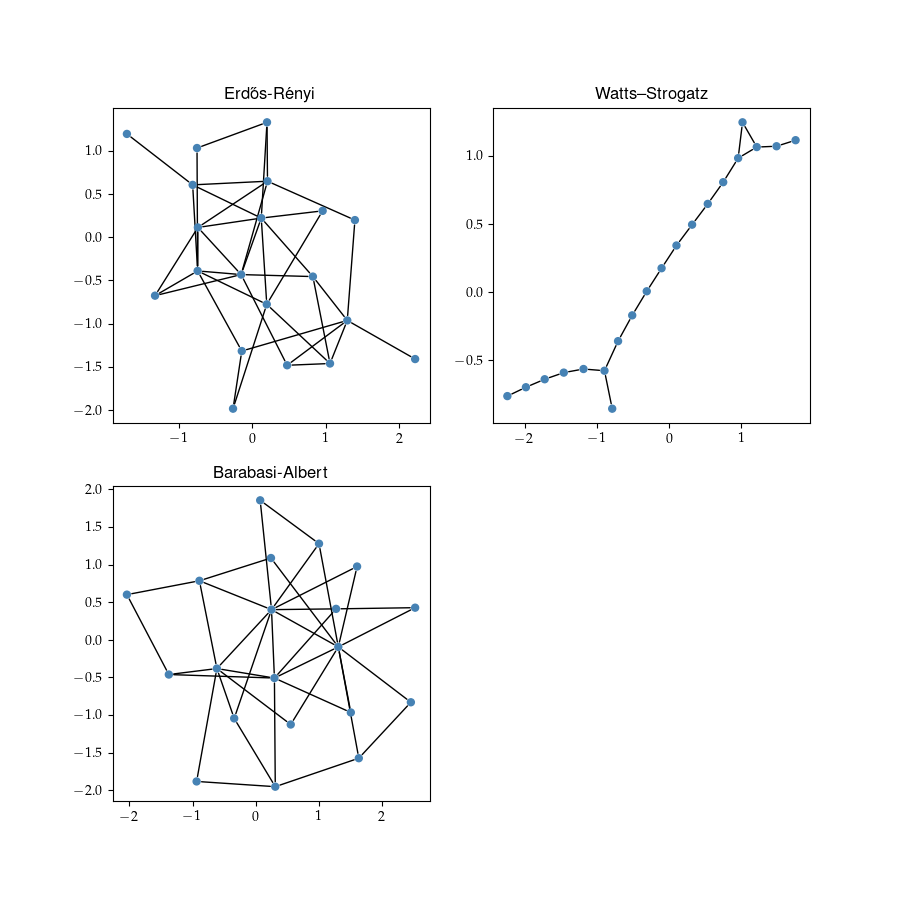

In [157]:
random.seed(0)
name_graph = {1: "Erdős-Rényi", 2: "Watts–Strogatz", 3: "Barabasi-Albert"}
# Generate Erdos Renyi graphs based on probability
g_erdos_renyi = ig.Graph.Erdos_Renyi(n=N, p=0.2, directed=False, loops=False)
g_watts_strogatz = ig.Graph.Watts_Strogatz(dim = 1, size = 20, nei = 1, p = 0.2)
g_barabasi_albert = ig.Graph.Barabasi(n = N, m = 2 )

# Print out summaries of each graph
print("Erdos-Renyi: {} \n Watts-Strogatz: {} \n Barabasi-Albert: {}".format(
    str(g_erdos_renyi), str(g_barabasi_albert), str(g_watts_strogatz)))


#new figure to plot network graphs
fig_graph = plt.figure(figsize = (9, 9) )
axs_graph = [fig_graph.add_subplot(2,2,1), fig_graph.add_subplot(2,2,2), fig_graph.add_subplot(2,2,3)]
ig.plot(g_erdos_renyi, target=axs_graph[0], color='pink')
ig.plot(g_watts_strogatz, target=axs_graph[1])
ig.plot(g_barabasi_albert, target=axs_graph[2])
for i in range(len(axs_graph)):  
    axs_graph[i].set(title=name_graph[i+1])


KeyboardInterrupt: 

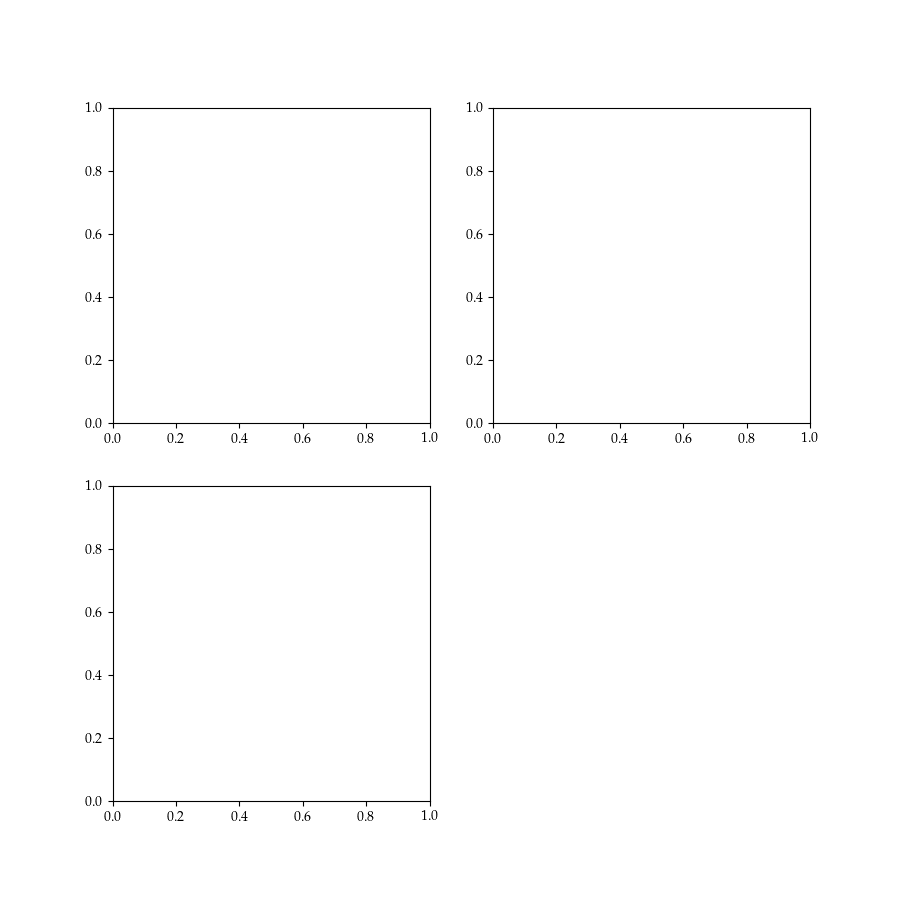

In [158]:
N = 20
dt = 0.001
t_max = 10
random.seed(0)
q_0 = np.random.rand(N)*2*np.pi
omegas = np.random.rand(N)
# for plotting
t_span = np.arange(0, t_max, dt)
K = 2
# Calculating and Plotting Q vs P
fig_plot = plt.figure(figsize = (9, 9) )
axs_plot = [fig_plot.add_subplot(2,2,1), fig_plot.add_subplot(2,2,2), fig_plot.add_subplot(2,2,3)]

q_plot_erd_ren, dq_plot_erd_ren = motion(q_0, omegas, K, t_max, dt, g_erdos_renyi)
axs_plot[0].clear()
axs_plot[0].plot(t_span[::], dq_plot_erd_ren[::, 0:20])

q_plot_watt_strog, dq_plot_watt_strog = motion(q_0, omegas, K, t_max, dt, g_watts_strogatz)
axs_plot[1].clear()
axs_plot[1].plot(t_span[::], dq_plot_watt_strog[::, 0:20])

q_plot_barabasi_albert, dq_plot_barabasi_albert = motion(q_0, omegas, K, t_max, dt, g_barabasi_albert)
axs_plot[2].clear()
axs_plot[2].plot(t_span[::], dq_plot_barabasi_albert[::, 0:20])

for i in range(len(axs_plot)):  
    axs_plot[i].set(xlabel="$t (s)$", ylabel=r"$\theta '$", title=name_graph[i+1])

fig_plot.suptitle("dQ vs t plot", fontsize = 16)

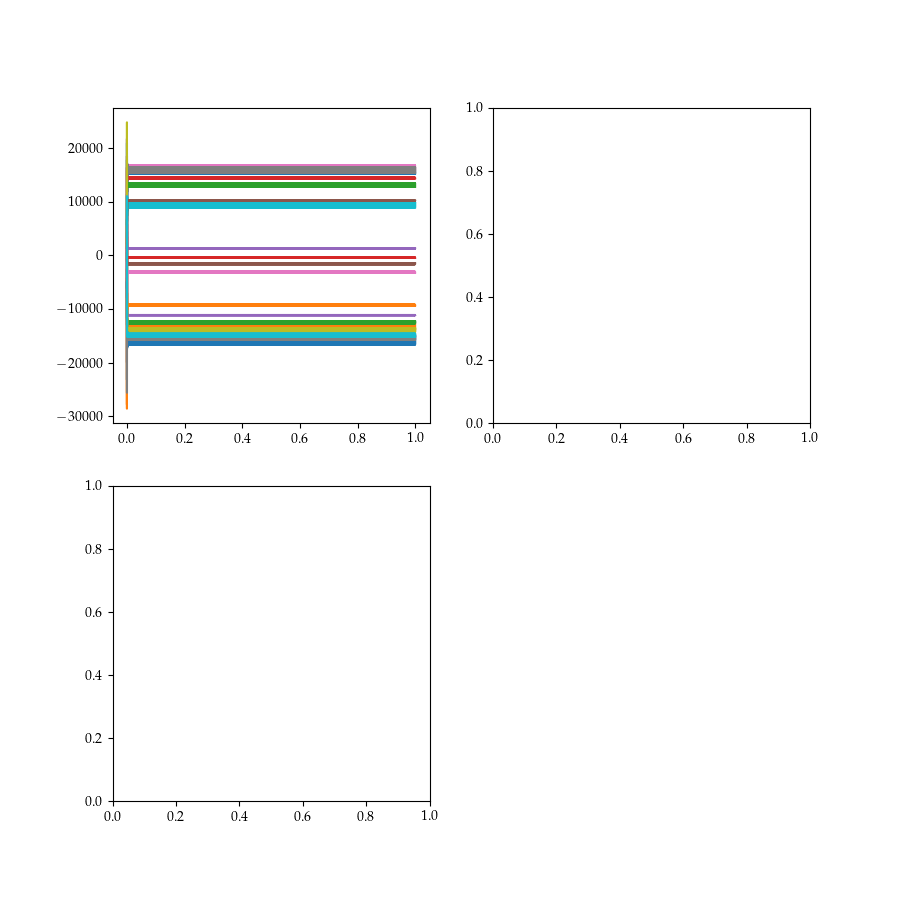

In [207]:
N = 20
dt = 0.0001
t_max = 1
random.seed(0)
q_0 = np.random.rand(N)*2*np.pi
omegas = np.random.rand(N)
# for plotting
t_span = np.arange(0, t_max, dt)
K = 20000
# Calculating and Plotting Q vs P
fig_plot = plt.figure(figsize = (9, 9) )
axs_plot = [fig_plot.add_subplot(2,2,1), fig_plot.add_subplot(2,2,2), fig_plot.add_subplot(2,2,3)]

q_plot_erd_ren, dq_plot_erd_ren = motion(q_0, omegas, K, t_max, dt, g_erdos_renyi)
axs_plot[0].clear()
axs_plot[0].plot(t_span[::], dq_plot_erd_ren[::, 0:20])


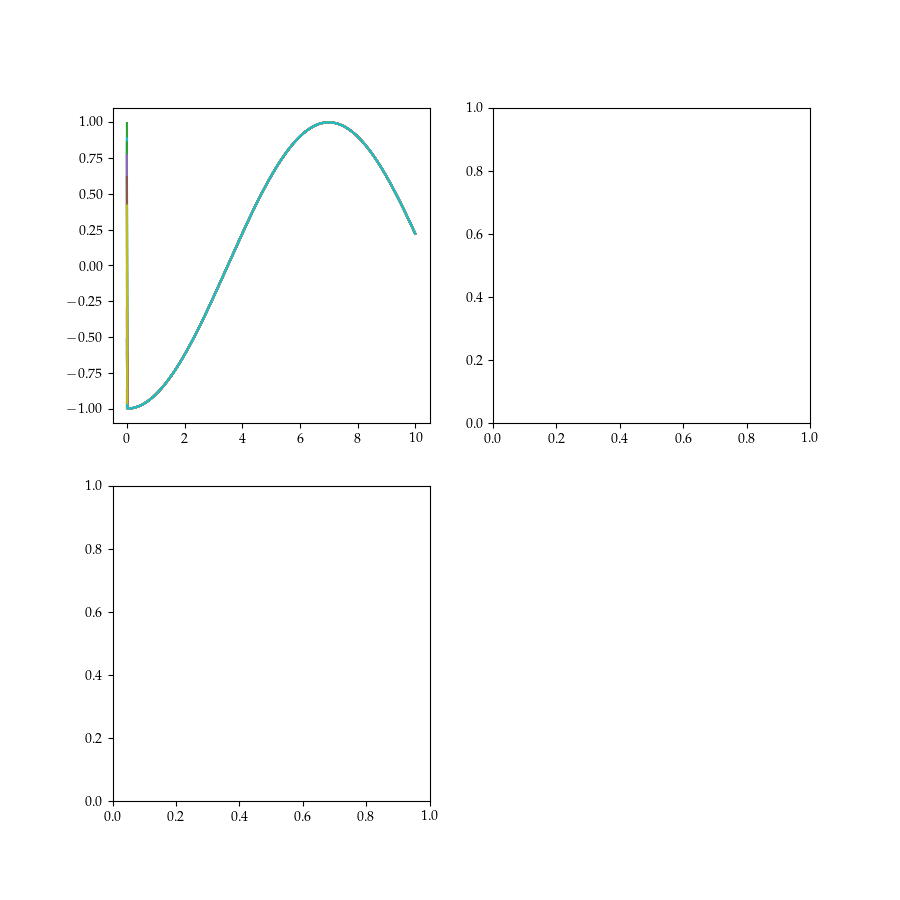

In [149]:
# plotting Q vs t
fig_plot_q_t = plt.figure(figsize = (9, 9) )
axs_plot_q_t = [fig_plot_q_t.add_subplot(2,2,1), fig_plot_q_t.add_subplot(2,2,2), fig_plot_q_t.add_subplot(2,2,3)]

axs_plot_q_t[0].clear()
axs_plot_q_t[0].plot(t_span[::10], np.sin(q_plot_erd_ren[::10, 0:20]))


In [90]:
axs_plot_q_dq[1].plot(t_span, sol.y[1])
fig_plot_q_dq.show()

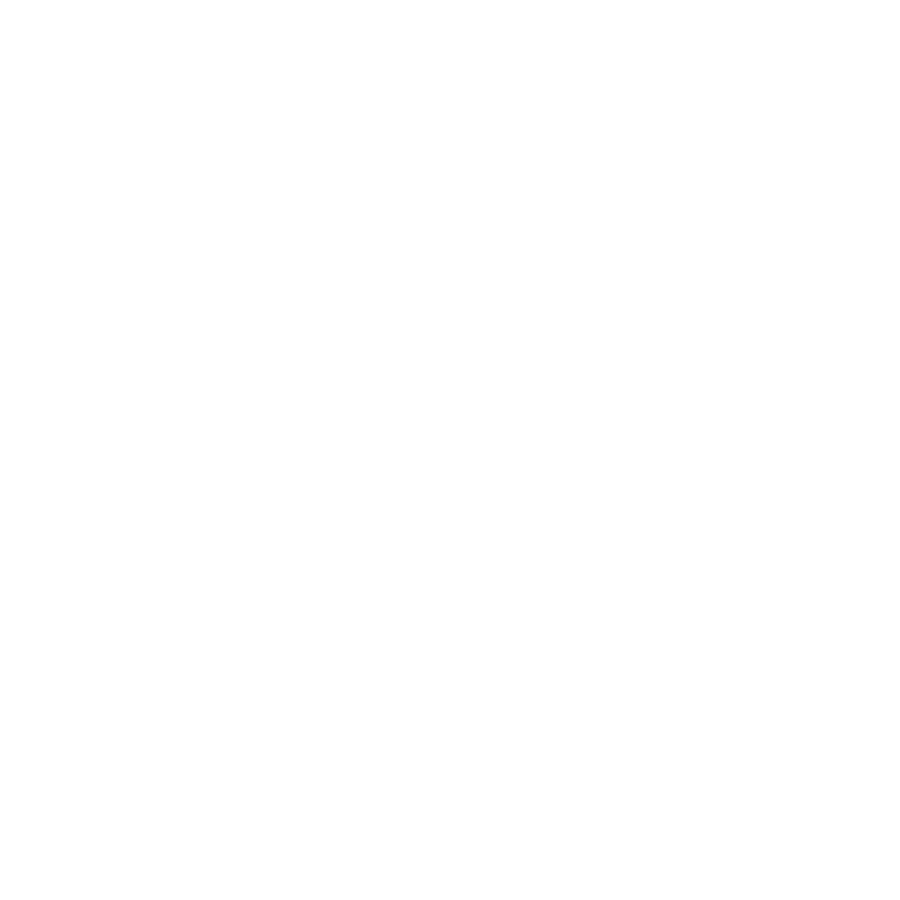

In [87]:
fig_plot_q_dq.show()

TypeError: unhashable type: 'slice'

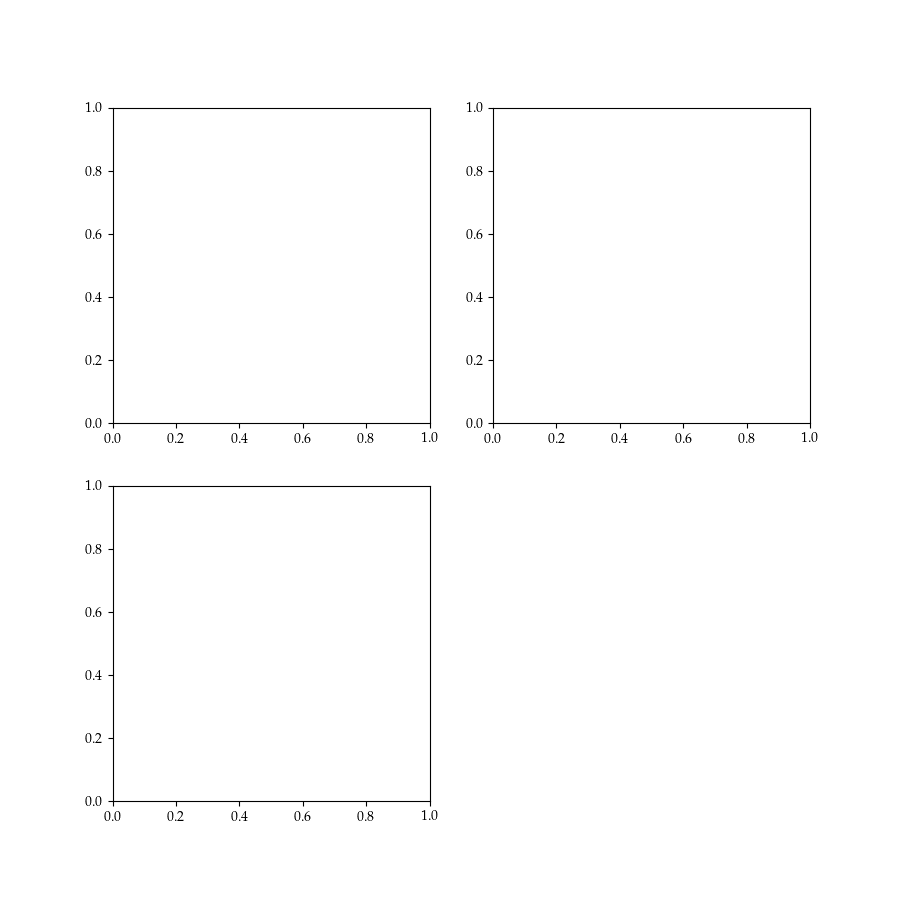

In [30]:
# plotting Q vs t
fig_plot_q_t = plt.figure(figsize = (9, 9) )
axs_plot_q_t = [fig_plot_q_t.add_subplot(2,2,1), fig_plot_q_t.add_subplot(2,2,2), fig_plot_q_t.add_subplot(2,2,3)]

axs_plot_q_t[0].clear()
axs_plot_q_t[0].plot(t_span[::10], q_plot_erd_ren[::10, 0:20])

axs_plot_q_t[1].clear()
axs_plot_q_t[1].plot(t_span[::10], q_plot_watt_strog[::10, 0:20])

axs_plot_q_t[2].clear()
axs_plot_q_t[2].plot(t_span[::10], q_plot_barabasi_albert[::10, 0:20])

for i in range(len(axs_plot_q_t)):  
    axs_plot_q_t[i].set(xlabel="$t (s)$", ylabel=r"$\theta$", title=name_graph[i+1])

fig_plot_q_t.suptitle("Q vs t plot", fontsize = 16)


### studiare il parametro d'ordine r di Kuramoto, in funzione del parametro di controllo K, e fare un plot r(K) vs K dove dovrebbe trovare una curva simile a quella di una transizione di fase (cosa che infatti è, si passa da moto disordinato a moto collettivo).

### fare la stessa simulazione (a parità di rete o di modello di rete) più e più volte, e poi mediare.

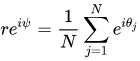

$r, \psi$ parametri d'ordine

nel caso di un network si può definire:

$ r =  \|  \sum_{j = 1}^N \frac{1}{k_j} e^{i \theta _i } \| \ , \ \ i = 1, ..., N$ 

$ r =  \frac{1}{N} \|  \sum_{j = 1}^N e^{i \theta _i } \| \ , \ \ i = 1, ..., N$ 

In [ ]:
N_atm = 20
q_0 = np.random.rand(N)*2*np.pi
omegas = np.random.rand(N)

K_start = 13.7
K_end = 14.9
K_step = 0.05
K_cycle = np.arange(K_start, K_end, K_step)

r_mean_erdos_renyi = []
print("network: {} , N: {} ".format(len(g_erdos_renyi.vs.indices), N_atm))
for K in K_cycle:
    q_temp = copy.deepcopy(q_0[0:N_atm:1])
    omegas_temp = copy.deepcopy(omegas[0:N_atm:1])
    r = kuramoto_r_mean(q_temp, omegas_temp, K, t_max, dt, g_erdos_renyi)
    r_mean_erdos_renyi.append(r)
    print(r_mean_erdos_renyi)
    print(K_cycle)

In [ ]:
random.seed(0)
N = 20

g_erdos_renyi = ig.Graph.Erdos_Renyi(n=N, p=0.2, directed=False, loops=False)
ig.plot(g_erdos_renyi)
N_start = N
N_end = N + 30
N_step = 2
N_cycle = np.arange(N_start, N_end, N_step)

q_0 = np.random.rand(N_end-1)*2*np.pi
omegas = np.random.rand(N_end-1)

K_start_max = 13.7
K_end_max = 14
K_step_max = 4
K_start_min = 50
K_end_min = 500
K_step_min = 50
K_cycle_max = np.arange(K_start_max, K_end_max, K_step_max)
K_cycle_min = np.arange(K_start_min, K_end_min, K_step_min)

r_max_erdos_renyi = []
r_min_erdos_renyi = []
for N_atm in N_cycle:
    r_mean_erdos_renyi = []
    print("network: {} , N: {} ".format(len(g_erdos_renyi.vs.indices), N_atm))
    for K in K_cycle_max:
        q_temp = copy.deepcopy(q_0[0:N_atm:1])
        omegas_temp = copy.deepcopy(omegas[0:N_atm:1])
        r = kuramoto_r_mean(q_temp, omegas_temp, K, t_max, dt, g_erdos_renyi)
        r_mean_erdos_renyi.append(r)
    r_max_erdos_renyi.append(np.max(r_mean_erdos_renyi))
    r_mean_erdos_renyi = []
    for K in K_cycle_min:
        q_temp = copy.deepcopy(q_0[0:N_atm:1])
        omegas_temp = copy.deepcopy(omegas[0:N_atm:1])
        r = kuramoto_r_mean(q_temp, omegas_temp, K, t_max, dt, g_erdos_renyi)
        r_mean_erdos_renyi.append(r)
    r_min_erdos_renyi.append(np.min(r_mean_erdos_renyi))
    g_erdos_renyi.add_vertices(N_step)



In [ ]:
K_start = 0
K_end = 100
K_step = 2
K_cycle = np.arange(K_start, K_end, K_step)

r_mean_erdos_renyi = []
for K in K_cycle:
    r = kuramoto_r_mean(q_0, omegas, K, t_max, dt, g_erdos_renyi)
    r_mean_erdos_renyi.append(r)


r_mean_barabasi_albert = []
for K in K_cycle:
    r = kuramoto_r_mean(q_0, omegas, K, t_max, dt, g_barabasi_albert)
    r_mean_barabasi_albert.append(r)

In [ ]:
K_start = 0
K_end = 25
K_step = 0.5
K_cycle = np.arange(K_start, K_end, K_step)

r_mean_watts_strogatz = []
for K in K_cycle:
    r = kuramoto_r_mean(q_0, omegas, K, t_max, dt, g_watts_strogatz)
    r_mean_watts_strogatz.append(r)
    

In [ ]:
plt.close

fig_plot_r_erdos_renyi = plt.figure(figsize = (9, 9) )
axs_plot_r_erdos_renyi = [fig_plot_r_erdos_renyi.add_subplot(2,2,1), fig_plot_r_erdos_renyi.add_subplot(2,2,2)]
axs_plot_r_erdos_renyi[0].clear()
axs_plot_r_erdos_renyi[0].plot(K_cycle[::], r_mean_erdos_renyi)
axs_plot_r_erdos_renyi[0].set(xlabel="$K$", ylabel=r"$r (K)$", title=name_graph[1])


fig_plot_r_watts_strogatz = plt.figure(figsize = (9, 9) )
axs_plot_r_watts_strogatz = [fig_plot_r_watts_strogatz.add_subplot(2,2,1), fig_plot_r_watts_strogatz.add_subplot(2,2,2)]
axs_plot_r_watts_strogatz[0].clear()
axs_plot_r_watts_strogatz[0].plot(K_cycle[::], r_mean_watts_strogatz)
axs_plot_r_watts_strogatz[0].set(xlabel="$K$", ylabel=r"$r (K)$", title=name_graph[2])

fig_plot_r_barabasi_albert = plt.figure(figsize = (9, 9) )
axs_plot_r_barabasi_albert = [fig_plot_r_barabasi_albert.add_subplot(2,2,1), fig_plot_r_barabasi_albert.add_subplot(2,2,2)]
axs_plot_r_barabasi_albert[0].clear()
axs_plot_r_barabasi_albert[0].plot(K_cycle[::], r_mean_barabasi_albert)
axs_plot_r_barabasi_albert[0].set(xlabel="$K$", ylabel=r"$r (K)$", title=name_graph[3])

ig.plot(g_erdos_renyi, target=axs_plot_r_erdos_renyi[1], color='pink')
ig.plot(g_watts_strogatz, target=axs_plot_r_watts_strogatz[1])
ig.plot(g_barabasi_albert, target=axs_plot_r_barabasi_albert[1])

In [ ]:
fig_plot_r_erdos_renyi.show()

In [ ]:
fig_plot_r_watts_strogatz.show()

In [ ]:
fig_plot_r_barabasi_albert.show()

In [ ]:
g_erdos_renyi.add_vertex()

In [ ]:
ig.plot(g_erdos_renyi)

In [ ]:
len(K_cycle)
r_v_max = 

In [ ]:
fig_plot_r = plt.figure(figsize = (9, 9) )
axs_plot_r= [fig_plot_r.add_subplot(2,2,1), fig_plot_r.add_subplot(2,2,2)]
axs_plot_r[0].clear()
axs_plot_r[0].plot( (N_cycle[::] - N_start) / N_end, r_min_erdos_renyi)
axs_plot_r[1].clear()
axs_plot_r[0].plot((N_cycle[::] - N_start)/ N_end, r_max_erdos_renyi)
axs_plot_r[0].set(ylabel="$r$", xlabel=r"Nodi liberi / Totali collegati", title="r_max e r_min con K_i = N_tot")
ig.plot(g_erdos_renyi, target = axs_plot_r[1])
axs_plot_r[1].set(title="Graf: {} N_start = {} N_end = {} con K_i = N".format(name_graph[1], N_start, N_end))